<a href="https://colab.research.google.com/github/raplima/2020_cores_auto/blob/master/pyscripts/detectron2_cores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 for object detection with core images

This project is built using [detectron2](https://github.com/facebookresearch/detectron2).  
Here, we will :
* Train a detectron2 model on a dataset of interpreted core images
* Compute the performance statistics
* Run inference on images with the newly trained detectron2 model

You can see a more complete example of detectron2 usage in their [notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).


# Install detectron2
As shown [here](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-5i33aolg
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-5i33aolg
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267014 sha256=baee01f8a0884e29b1f9dfb683a3c5b3b7433bc8f6be2a631e2e8b62e713a95f
  Stored in directory: /tmp/pip-ephem-wheel-cache-1tmfqf96/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# import the remaining of the necessary modules
import os
import json

from detectron2.structures import BoxMode
# to train
from detectron2.engine import DefaultTrainer
# to evaluate
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Train on a custom dataset

In this section, we will train an existing detectron2 model on a custom dataset in a new format.

We use the dataset with interpreted lithofacies.
We'll train a new segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "new" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [0]:
# download, decompress the data
#!wget --no-check-certificate -r 'https://sooners-my.sharepoint.com/:u:/g/personal/rlima_ou_edu/EYV0o7UIPzRNrhGFr_WMhSFlQ?e=YQtIaJ' -O Van_Horn_Well.zip
!unzip vanhorn_and_hawkins.zip > /dev/null

Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
def get_data_dicts(img_dir):
    # get the classes:
    json_file = os.path.join(img_dir, "classes.txt")
    with open(json_file) as f:
        ann_classes = json.load(f)
    # transform the dictionary into a list 
    classes=sorted([it for _, it in ann_classes.items()])

    json_file = os.path.join(img_dir, "vanhorn_hawkins_final_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            #assert not anno["region_attributes"]
            region = anno['region_attributes']
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(ann_classes[region['lithofacies']]),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
path_train = 'vanhorn_and_hawkins'
path_val = 'vanhorn_and_hawkins'
dataset_tag = 'well_'
json_file = os.path.join(path_train, "classes.txt")
with open(json_file) as f:
    classes = json.load(f)

for d in ["train", "val"]:
  DatasetCatalog.register(dataset_tag + d, lambda d=d: get_data_dicts(path_train))
  MetadataCatalog.get(dataset_tag + d).set(thing_classes=sorted([it for _, it in classes.items()]))

train_metadata = MetadataCatalog.get(f"{dataset_tag}train")
val_metadata = MetadataCatalog.get(f"{dataset_tag}val")
print('ok')

ok


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



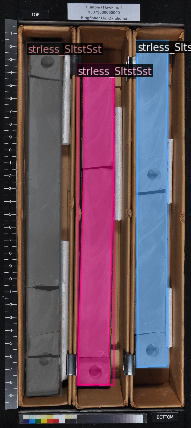

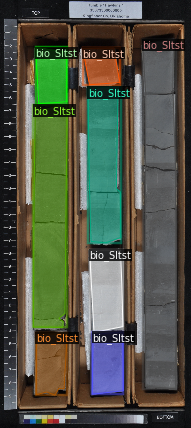

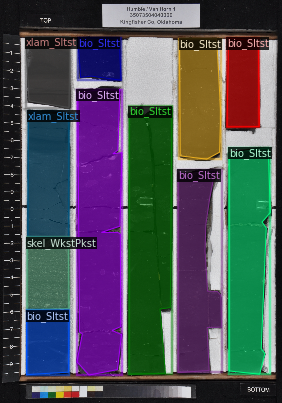

In [6]:
dataset_dicts = get_data_dicts(path_train)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~22 minutes to train 1000 iterations on Colab's K80 GPU, or ~20 minutes on a P100 GPU.


In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{dataset_tag}train",)
cfg.DATASETS.TEST = (f"{dataset_tag}val",)
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)   # number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

# print GPU information
!nvidia-smi

[06/15 18:00:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (7,) in the model!


Mon Jun 15 18:00:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    989MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
trainer.train()

[06/15 18:00:53 d2.engine.train_loop]: Starting training from iteration 0
[06/15 18:01:12 d2.utils.events]:  eta: 0:14:37  iter: 19  total_loss: 4.226  loss_cls: 2.017  loss_box_reg: 0.766  loss_mask: 0.694  loss_rpn_cls: 0.492  loss_rpn_loc: 0.314  time: 0.9210  data_time: 0.6749  lr: 0.000005  max_mem: 2665M
[06/15 18:01:30 d2.utils.events]:  eta: 0:13:49  iter: 39  total_loss: 3.948  loss_cls: 1.892  loss_box_reg: 0.806  loss_mask: 0.688  loss_rpn_cls: 0.308  loss_rpn_loc: 0.270  time: 0.8977  data_time: 0.6043  lr: 0.000010  max_mem: 2760M
[06/15 18:01:49 d2.utils.events]:  eta: 0:13:50  iter: 59  total_loss: 3.507  loss_cls: 1.602  loss_box_reg: 0.812  loss_mask: 0.676  loss_rpn_cls: 0.133  loss_rpn_loc: 0.189  time: 0.9151  data_time: 0.6876  lr: 0.000015  max_mem: 2760M
[06/15 18:02:07 d2.utils.events]:  eta: 0:13:27  iter: 79  total_loss: 3.173  loss_cls: 1.309  loss_box_reg: 0.839  loss_mask: 0.653  loss_rpn_cls: 0.080  loss_rpn_loc: 0.219  time: 0.9114  data_time: 0.6445  lr:

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output
# images can be exported as SVG for further edits before publication

Reusing TensorBoard on port 6006 (pid 1570), started 3:17:23 ago. (Use '!kill 1570' to kill it.)

<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (f"{path_val}_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

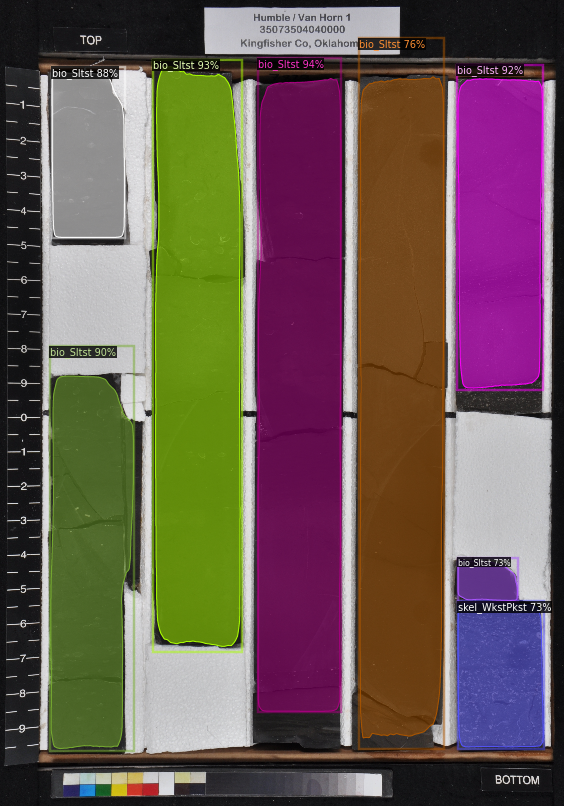

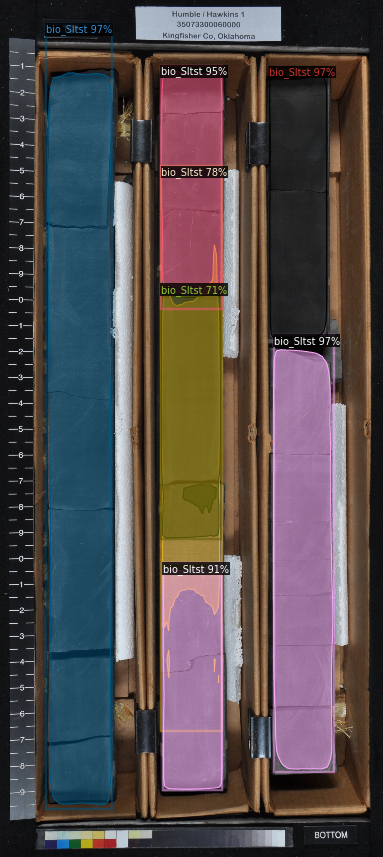

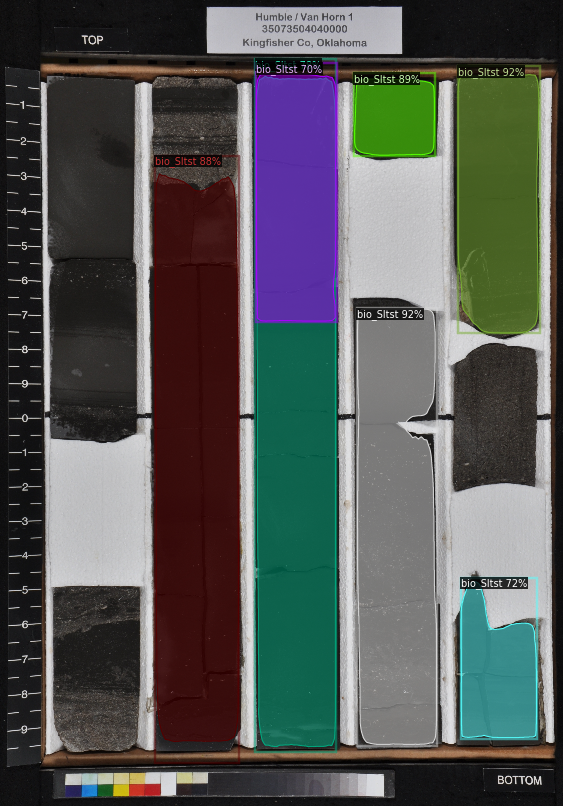

In [11]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_data_dicts(path_val)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.2, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite(f'{d["file_name"]}_predicted.png', v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [12]:
evaluator = COCOEvaluator(f"{dataset_tag}val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, f"{dataset_tag}val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [06/15 18:16:06 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'well_val'. Trying to convert it to COCO format ...
[06/15 18:16:06 d2.data.datasets.coco]: Converting annotations of dataset 'well_val' to COCO format ...)
[06/15 18:16:18 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/15 18:16:18 d2.data.datasets.coco]: Conversion finished, num images: 54, num annotations: 451
[06/15 18:16:18 d2.data.datasets.coco]: Caching COCO format annotations at './output/well_val_coco_format.json' ...
[06/15 18:16:29 d2.data.common]: Serializing 54 elements to byte tensors and concatenating them all ...
[06/15 18:16:29 d2.data.common]: Serialized dataset takes 0.12 MiB
[06/15 18:16:29 d2.evaluation.evaluator]: Start inference on 54 images
[06/15 18:17:20 d2.evaluation.evaluator]: Inference done 11/54. 0.1839 s / img. ETA=0:03:16
[06/15 18:17:30 d2.evaluation.evaluator]: Inference done 13/54. 0.1860 s / img. ETA=0:03:11
[06/15 18:17:37 d2

OrderedDict([('bbox',
              {'AP': 54.532693500915826,
               'AP-bio_Sltst': 67.21172255059074,
               'AP-brec_Cht': 64.35252500205607,
               'AP-glauc_Sltst': 75.04950495049505,
               'AP-lam_Sltst': 34.93635209430606,
               'AP-skel_WkstPkst': 55.45512857998421,
               'AP-strless_SltstSst': 71.70122789369884,
               'AP-xlam_Sltst': 13.022393435279845,
               'AP50': 74.93170671894013,
               'AP75': 66.45822937244994,
               'APl': 54.53310582240378,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 58.585713640354896,
               'AP-bio_Sltst': 72.39007973171553,
               'AP-brec_Cht': 71.7484625289994,
               'AP-glauc_Sltst': 82.52475247524752,
               'AP-lam_Sltst': 35.9542028825671,
               'AP-skel_WkstPkst': 60.21761359848574,
               'AP-strless_SltstSst': 73.32679621865108,
               'AP-

In [14]:
  # donwload images with results
from google.colab import files
res = os.listdir(path_val)
for r in res:
    if 'predicted' in r:
        print(r)
        files.download(os.path.join(path_val, r))

Box 11 Depths 7825-7835.JPG_predicted.png
Box 3 Depths 7745-7755.JPG_predicted.png
Boxes 13-15  Depths 7753.1-7762 (Dry).JPG_predicted.png


In [0]:
# delete folders
!rm -r output
!rm -r vanhorn_and_hawkins